# 指标计算(整体对应evalution_segmentation.py)

1. 相关指标简介
2. 混淆矩阵形成过程
3. 指标计算过程

In [0]:
from __future__ import division
import torch
import torch.nn.functional as F
import numpy as np
import six
import matplotlib.pyplot as plt

### Documentation of funcs:
Evaluate metrics used in Semantic Segmentation.

This function calculates Intersection over Union (IoU), Pixel Accuracy
and Class Accuracy for the task of semantic segmentation.

The definition of metrics calculated by this function is as follows,
where $N_{ij}$ is the number of pixels that are labeled as class $i$ by the ground truth and class $j$ by the prediction.


$\text{IoU of the i-th class} =  \frac{N_{ii}}{\sum_{j=1}^k N_{ij} + \sum_{j=1}^k N_{ji} - N_{ii}}$

$\text{mIoU} = \frac{1}{k} 
        \sum_{i=1}^k 
        \frac{N_{ii}}{\sum_{j=1}^k N_{ij} + \sum_{j=1}^k N_{ji} - N_{ii}}$

$\text{Pixel Accuracy} =  
        \frac 
        {\sum_{i=1}^k N_{ii}} 
        {\sum_{i=1}^k \sum_{j=1}^k N_{ij}}$

$\text{Class Accuracy} = 
        \frac{N_{ii}}{\sum_{j=1}^k N_{ij}}$

$\text{Mean Class Accuracy} = \frac{1}{k} 
        \sum_{i=1}^k 
        \frac{N_{ii}}{\sum_{j=1}^k N_{ij}}$

The number of classes $n\_class$ is $max(pred\_labels, gt\_labels) + 1$, which is the maximum class id of the inputs added by one.

The more detailed description of the above metrics can be found in a review on semantic segmentation Alberto Garcia-Garcia, Sergio Orts-Escolano, Sergiu Oprea, Victor Villena-Martinez, Jose Garcia-Rodriguez.  [A Review on Deep Learning Techniques Applied to Semantic Segmentation](https://arxiv.org/abs/1704.06857>). arXiv 2017.

In [3]:
%%html
<img src="23.png", width=700, heigth=700>
<img src="24.png", width=700, heigth=700>

In [57]:
# fake label data
gt = np.random.rand(1, 2, 3)*12
gt = gt.astype(np.int64)
gt = torch.from_numpy(gt)

x = torch.randn(1, 12, 2, 3)  # 假设每个像素点可以对应12个分类
out = F.log_softmax(x, dim=1)

print(gt)
print('='*40)
print(out)

tensor([[[ 1, 11,  9],
         [ 6,  4, 11]]])
tensor([[[[-3.6364, -2.5271, -2.6061],
          [-3.6993, -3.7676, -3.7860]],

         [[-2.8848, -2.2626, -1.8794],
          [-1.3549, -1.9828, -1.0390]],

         [[-2.4099, -2.7261, -2.3141],
          [-2.5346, -3.4321, -2.5286]],

         [[-3.8668, -2.6031, -3.1582],
          [-2.8502, -4.0885, -3.3225]],

         [[-3.7301, -2.7621, -3.6439],
          [-2.5944, -2.1272, -3.3256]],

         [[-4.0690, -2.2244, -1.8543],
          [-2.1628, -4.8737, -5.3196]],

         [[-1.9503, -4.2843, -1.8384],
          [-3.6383, -4.4557, -1.6903]],

         [[-1.1397, -4.2204, -2.9541],
          [-1.8096, -1.2834, -4.5804]],

         [[-1.6517, -1.5704, -3.0781],
          [-2.3460, -4.1107, -2.9618]],

         [[-3.4865, -1.7748, -2.1138],
          [-3.2565, -1.7787, -4.2973]],

         [[-4.3939, -2.5988, -2.8379],
          [-3.1677, -2.0229, -2.5436]],

         [[-2.6719, -3.6926, -4.3535],
          [-3.7267, -2.8635, -2.0

In [58]:
pred_labels = out.max(dim=1)[1].data.cpu().numpy()  # ndarray
pred_labels = [i for i in pred_labels]  # list
print(pred_labels)  # 
gt_labels = gt.data.cpu().numpy()
gt_labels = [i for i in gt_labels]
print(gt_labels)

[array([[7, 8, 6],
       [1, 7, 1]])]
[array([[ 1, 11,  9],
       [ 6,  4, 11]])]


In [54]:
for pred_label, gt_label in six.moves.zip(pred_labels, gt_labels):
    print(pred_label.ndim, gt_label.ndim)
    print(pred_label.shape, gt_label.shape)

2 2
(2, 3) (2, 3)


In [55]:
pred_label, gt_label = pred_labels[0], gt_labels[0]
pred_label = pred_label.flatten()
gt_label = gt_label.flatten()
print(pred_label)
print(gt_label)
np.max((pred_label, gt_label))

[8 3 7 9 6 8]
[10 11  7  3  4 10]


11

In [59]:
mask = gt_label >= 0 
mask     

array([ True,  True,  True,  True,  True,  True])

In [64]:
gt_label[mask]

array([10, 11,  7,  3,  4, 10])

In [65]:
12*gt_label[mask] 

array([120, 132,  84,  36,  48, 120])

In [66]:
12*gt_label[mask] + pred_label[mask]

array([128, 135,  91,  45,  54, 128])

### [numpy.bincount](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html)
　　Each bin gives the number of occurrences of its index value in x.

In [0]:
# >>> np.bincount(np.arange(5))
# array([1, 1, 1, 1, 1])
# >>> np.bincount(np.array([0, 1, 1, 3, 2, 1, 7]))
# array([1, 3, 1, 1, 0, 0, 0, 1])

In [74]:
confusion_onedim = np.zeros((144,), dtype=np.int64)
confusion_onedim += np.bincount(
        12 * gt_label[mask].astype(int) + pred_label[mask],   # 类似12进制了
        minlength=12 ** 2)
print(confusion_onedim.shape)
print(confusion_onedim)

(144,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [78]:
confusion = np.zeros((12, 12), dtype=np.int64)
confusion += np.bincount(
        12 * gt_label[mask].astype(int) + pred_label[mask],   # 类似12进制了
        minlength=12 ** 2).reshape((12, 12))
confusion

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

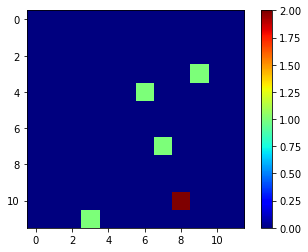

In [79]:
cm = confusion
plt.figure()
plt.grid(False)
plt.imshow(cm, cmap='jet')
plt.colorbar()
plt.show()


### [next()](https://www.programiz.com/python-programming/methods/built-in/next)
The syntax of next() is:

`next(iterator, default)`

next() Parameters:

* iterator - next() retrieves next item from the iterator

* default (optional) - this value is returned if the iterator is exhausted (there is no next item)

In [0]:
def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    """Collect a confusion matrix. 计算 混淆矩阵
    The number of classes `n_class` is `max(pred_labels, gt_labels) + 1`, which is
    the maximum class id of the inputs added by one.
    Args:
        pred_labels(iterable of numpy.ndarray): A collection of predicted
            labels. The shape of a label array
            is `(H, W)`. `H` and `W`
            are height and width of the label.
        gt_labels(iterable of numpy.ndarray): A collection of ground
            truth labels. The shape of a ground truth label array is
            `(H, W)`, and its corresponding prediction label should
            have the same shape.
            A pixel with value `-1` will be ignored during evaluation.
    Returns:
        numpy.ndarray:
        A confusion matrix. Its shape is `(n_class, n_class)`.
        The `(i, j)` th element corresponds to the number of pixels
        that are labeled as class `i` by the ground truth and
        class `j` by the prediction.
    """
    pred_labels = iter(pred_labels)

    gt_labels = iter(gt_labels)

    n_class = 12
    # 定义一个数值容器 shape(12,12)
    confusion = np.zeros((n_class, n_class), dtype=np.int64)
    
    for pred_label, gt_label in six.moves.zip(pred_labels, gt_labels):  # six.moves.zip in python2
        if pred_label.ndim != 2 or gt_label.ndim != 2:
            raise ValueError('ndim of labels should be two.')
        if pred_label.shape != gt_label.shape:
            raise ValueError(
                'Shape of ground truth and prediction should be same.')
        pred_label = pred_label.flatten()
        gt_label = gt_label.flatten()

        # Dynamically expand the confusion matrix if necessary.
        lb_max = np.max((pred_label, gt_label))
        # print(lb_max)
        if lb_max >= n_class:
            expanded_confusion = np.zeros(
                (lb_max + 1, lb_max + 1), dtype=np.int64)
            expanded_confusion[0:n_class, 0:n_class] = confusion

            n_class = lb_max + 1
            confusion = expanded_confusion  # 原来的confusion矩阵就没有了，被expanded_confusion替换了

        # Count statistics from valid pixels. 
        mask = gt_label >= 0
        confusion += np.bincount(
            n_class * gt_label[mask].astype(int) + pred_label[mask],  # 这样处理axis=0 代表gt axis=1 代表pred……
            minlength=n_class ** 2) \                  # ……即 横表示gt ; 列表示pred 
            .reshape((n_class, n_class))  # 抓住一个点，混淆矩阵中，对角线上的点是分类正确的

    for iter_ in (pred_labels, gt_labels):
        # This code assumes any iterator does not contain None as its items.
        if next(iter_, None) is not None:
            raise ValueError('Length of input iterables need to be same')

    # confusion = np.delete(confusion, 11, axis=0)
    # confusion = np.delete(confusion, 11, axis=1)
    return confusion


In [0]:
def calc_semantic_segmentation_iou(confusion):
    """Calculate Intersection over Union with a given confusion matrix.
    Args:
        confusion (numpy.ndarray): A confusion matrix. Its shape is
            `(n_class, n_class)`.
            The `(i, j)`th element corresponds to the number of pixels
            that are labeled as class `i` by the ground truth and
            class `j` by the prediction.
    Returns:
        numpy.ndarray:
        An array of IoUs for the `n_class` classes. Its shape is `(n_class,)`.
    """
    # iou_denominator 并集  np.diag(confusion) 交集
    iou_denominator = (
        confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion)) 
    iou = np.diag(confusion) / iou_denominator
    return iou[:-1]  # 去掉最后一个类别，因为最后一个类别为 unlabelled
    # return iou


The definition of Intersection over Union (IoU) is as follows,
where $N_{ij}$ is the number of pixels
that are labeled as class $i$ by the ground truth and
class $j$ by the prediction.

$\text{IoU of the i-th class} =  \frac{N_{ii}}{\sum_{j=1}^k N_{ij} + \sum_{j=1}^k N_{ji} - N_{ii}}$

In [0]:
def eval_semantic_segmentation(pred_labels, gt_labels):
    """Evaluate metrics used in Semantic Segmentation
    Args:
        pred_labels (iterable of numpy.ndarray): A collection of predicted
            labels. The shape of a label array
            is (H, W). H and W are height and width of the label.
            For example, this is a list of labels [label_0, label_1, ...], 
            where label_i.shape = (H_i, W_i).
        gt_labels (iterable of numpy.ndarray): A collection of ground
            truth labels. The shape of a ground truth label array is
            (H, W), and its corresponding prediction label should
            have the same shape.
            A pixel with value `-1` will be ignored during evaluation.
    Returns:
        dict:

        The keys-value types and the description of the values are listed
        below.
        * iou(numpy.ndarray): An array of IoUs for the 
            `n_class` classes. Its shape is `(n_class,)`.
        * miou(float): The average of IoUs over classes.
        * pixel_accuracy(float): The computed pixel accuracy.
        * class_accuracy(numpy.ndarray): An array of class accuracies 
            for the `n_class` classes. 
            Its shape is `(n_class,)`.
        * mean_class_accuracy(float): The average of class accuracies.

        Evaluation code is based on
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/
        score.py #L37

    """
    confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
    iou = calc_semantic_segmentation_iou(confusion)
    pixel_accuracy = np.diag(confusion).sum() / confusion.sum()
    class_accuracy = np.diag(confusion) / (np.sum(confusion, axis=1) + 1e-10)

    return {'iou': iou, 'miou': np.nanmean(iou),
        'pixel_accuracy': pixel_accuracy,
        'class_accuracy': class_accuracy,
        'mean_class_accuracy': np.nanmean(class_accuracy[:-1])}
            # 'mean_class_accuracy': np.nanmean(class_accuracy)}

In [31]:
eval_metrix = eval_semantic_segmentation(pred_labels, gt_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


**RuntimeWarning: invalid value encountered in true_divide**

　　Maybe your code is trying to "divide by zero" or "divide by NaN". If you are aware of that and don't want it to bother you, then you can try:

    import numpy as np
    np.seterr(divide='ignore', invalid='ignore')

In [32]:
print(eval_metrix['miou'])

0.4666666666666667
